# Visualizing Time Series Data

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

from random import random

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.tsa.api as smt

import statsmodels.api as sm

import itertools, calendar

#Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller

# 1. Visualizing Time Series Data

** Using a real-world anonymised dataset from e-commerce retailers, this notebooks provides a workflow for time series visualization and decmosposition. 
I have cleaned the input sales data and sorted in in chronolgical decreasing order in offline steps.**


In [3]:
# Load analytical base table 
df = pd.read_csv("sorted_txs.csv", usecols=[0,1,2], parse_dates=["report_date"], low_memory=False)

In [4]:
df.shape, df["supplier_key"].nunique()

((278975, 3), 284)

The data is descending chronological order and sorted by supplier_key. Currentrly it is in daily order with a lot of 0 values. We will roll it up into monthly values for the time series analysis.
The dataset contains sales history for 284 retailers. For testing purposes we will concentrate on the data from retailer/supplier 1 which has 1079 daily transactions.

In [5]:
df1 = df[df["supplier_key"]==1]

In [6]:
print(df1.shape, "\n", df1[df1 == 0].count(axis=0)/len(df1.index))

(1079, 3) 
 supplier_key             0.000000
report_date              0.000000
ordered_product_sales    0.159407
dtype: float64


16% of entries are 0 valued, i.e, no sales recorded on thatdate.
I will roll the values up into monthly sales figures.
Let's compare plots of daily, weekly and monthly sales data

In [7]:
#this method removes leading and trailing zeros from the sales figures.
df1 = df1[(df1["ordered_product_sales"].eq(0).cumprod().eq(0))&(df1["ordered_product_sales"][::-1].eq(0).cumprod().eq(0))]  

In [8]:
#index the data by report date. This makes it easier to resample. Also drop the supplier_key.
df1.set_index("report_date", inplace=True)
df1_daily = df1.drop(["supplier_key"], axis=1)

In [9]:
#roll-up the daily sales data into weekly sales values
df1_weekly = df1_daily.resample('W').sum()

In [10]:
df1_daily.tail(14), df1_weekly.head(2) 

(             ordered_product_sales
 report_date                       
 2016-03-13                  205.66
 2016-03-12                  205.11
 2016-03-11                  268.48
 2016-03-10                  185.86
 2016-03-09                   71.84
 2016-03-08                  404.12
 2016-03-07                    0.00
 2016-03-06                    0.00
 2016-03-05                    0.00
 2016-03-04                    0.00
 2016-03-03                    0.00
 2016-03-02                    0.00
 2016-03-01                    0.00
 2016-02-29                   46.42,              ordered_product_sales
 report_date                       
 2016-03-06                   46.42
 2016-03-13                 1341.07)

In [11]:
#roll-up the daily sales data into monthly sales values
df1_monthly = df1_daily.resample('M').sum()

**For most of this analysis I focus on the monthly sales figures. Our real-world data looks like this:**

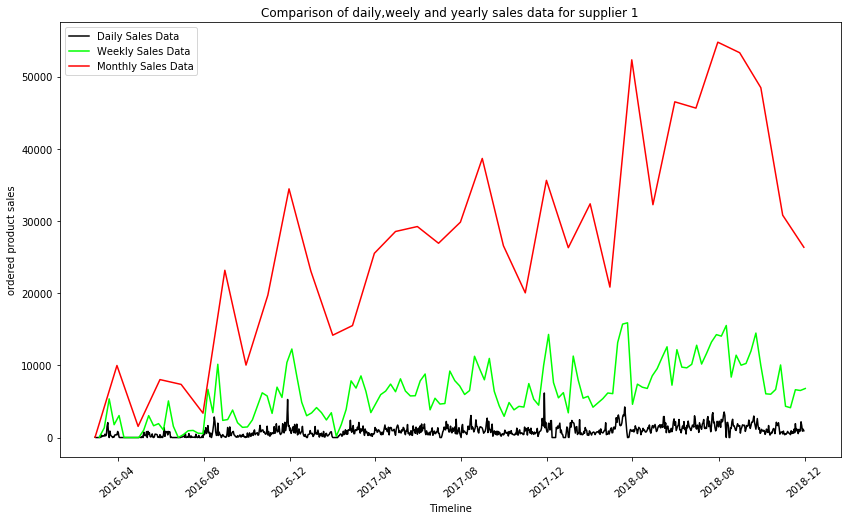

In [12]:
fig = plt.figure(figsize=[14,8]);
ax = fig.add_subplot(111);
ax.plot(df1_daily, color = (0,0,0), label = 'Daily Sales Data');
ax.plot(df1_weekly, color = (0,1,0), label = 'Weekly Sales Data');
ax.plot(df1_monthly, color = (1,0,0), label = 'Monthly Sales Data');
ax.set_title('Comparison of daily,weely and yearly sales data for supplier 1')
plt.xticks(rotation=40)
ax.set_xlabel('Timeline')
ax.set_ylabel('ordered product sales')
ax.legend(loc='upper left');

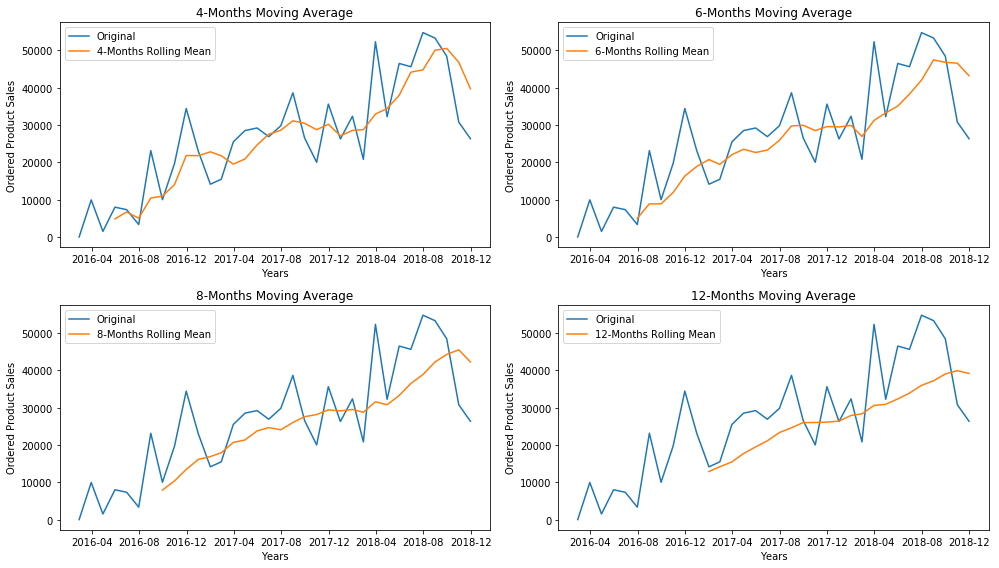

In [13]:
sales_ts = df1_monthly['ordered_product_sales']
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(df1_monthly.index, sales_ts, label='Original')
axes[0][0].plot(df1_monthly.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Ordered Product Sales")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(df1_monthly.index, sales_ts, label='Original')
axes[0][1].plot(df1_monthly.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Ordered Product Sales")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(df1_monthly.index, sales_ts, label='Original')
axes[1][0].plot(df1_monthly.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Ordered Product Sales")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(df1_monthly.index, sales_ts, label='Original')
axes[1][1].plot(df1_monthly.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Ordered Product Sales")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()



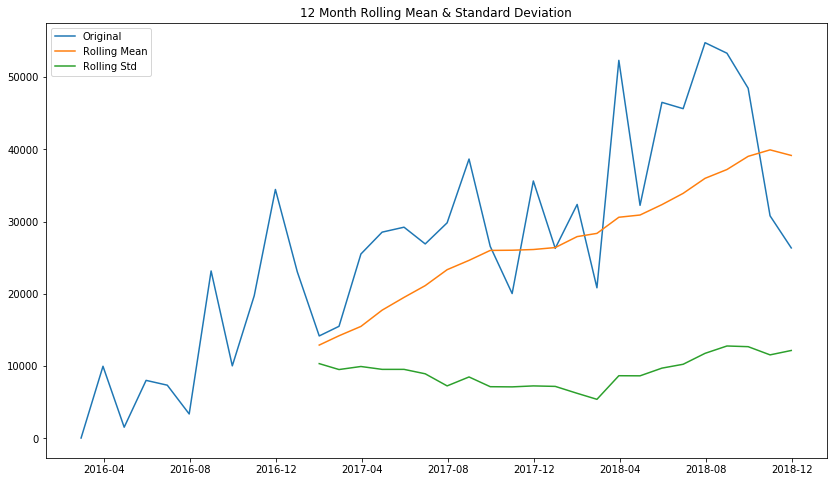

In [15]:
fig = plt.figure(figsize=[14,8]);

#Determing rolling statistics
rolmean = df1_monthly.rolling(window=12).mean()
rolstd = df1_monthly.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('12 Month Rolling Mean & Standard Deviation')
plt.show(block=False)



In [18]:
#add year and month columns for the net two plots
df1_monthly['year'], df1_monthly['month'] = df1_monthly.index.year, df1_monthly.index.month
df1_monthly['month'] = df1_monthly['month'].apply(lambda x: calendar.month_abbr[x])

In [19]:
monthly_sales_data = pd.pivot_table(df1_monthly, values = "ordered_product_sales", columns = "year", index = "month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

year,2016,2017,2018
month,,,
Jan,NaN,14177.89,32378.15
Feb,46.42,15510.40,20841.51
Mar,9980.35,25519.38,52323.83
Apr,1543.86,28544.78,32255.19
May,8027.15,29230.32,46507.34
Jun,7361.52,26913.89,45636.61
Jul,3376.18,29834.64,54769.03
Aug,23170.11,38663.57,53309.61
Sep,10037.73,26572.50,48460.61


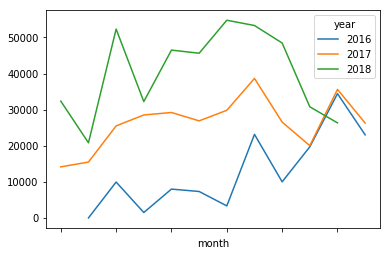

In [24]:
monthly_sales_data.plot()

** Sales for Q3-Q4 2018 are very different from the same cycyles in 2016 and 2017. 
This is going to be very difficult to predict based on historical data. **

In [21]:
yearly_sales_data = pd.pivot_table(df1_monthly, values = "ordered_product_sales", columns = "month", index = "year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2016,NaN,46.42,9980.35,1543.86,8027.15,7361.52,3376.18,23170.11,10037.73,19736.97,34451.37,23041.77
2017,14177.89,15510.40,25519.38,28544.78,29230.32,26913.89,29834.64,38663.57,26572.50,20044.21,35627.76,26300.14
2018,32378.15,20841.51,52323.83,32255.19,46507.34,45636.61,54769.03,53309.61,48460.61,30803.33,26359.73,NaN


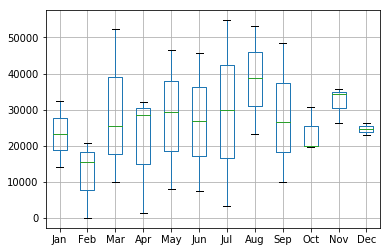

In [22]:
yearly_sales_data.boxplot()

* Sales have been increasing yearly from Q1-Q3. However in 2018 sales drop below 2016 and 2017 levels in Q4.
* July and August are the peak months for sales. The variance is highest in July and August has the highet mean sales level.
* It is difficult to see a clear seasonal cycle. The ADF test tells us that this data is non-stationary but the data plots do not show a clear 12 month cycle.

# 2 Time Series Decomposition
The statsmodels library provides a seasonal decomposition method for decomposing time series data into trend and seasonal components. I will use a dummy dataset here for comparative purposes in the following analysis. Note that the statsmodel documentation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html calls this a naive method so we should use its results carefully. To see why decomposition results must be carefully interpreted we can generate 144 random ints and check for seasonality.

In [21]:
np.random.seed(100)
s = pd.Series(np.random.randn(100))

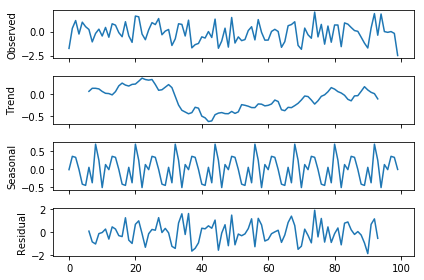

In [22]:
decomposition = seasonal_decompose(s, model='additative', freq=12)
fig = decomposition.plot()
plt.show()

** Even thought his data is ransom, we can see that the decomposition plot shows a seasonal cycle! The seasonal decomposition plots below for both the dummy data set and our real world dataset show that if seasonality exists then it will be shown - *however* - these plots are not intended to be used to establish the presence of seasonality as is often done.**

In [23]:
dummy_data = {
'ds':['2016-01-31','2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',\
     '2016-07-31', '2016-08-31', '2016-09-30','2016-10-31','2016-11-30','2016-12-31','2017-01-31',\
    '2017-02-28','2017-03-31','2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31', \
      '2017-09-30','2017-10-31','2017-11-30','2017-12-31'],
'y': [4,5,4, 8,9,10, 5,4,5, 7,8,7,  5,5,6, 9,10,11, 5,6,6, 8,9,9]
}

In [24]:
dummy_df = pd.DataFrame(dummy_data) 
dummy_df.ds = pd.to_datetime(dummy_df.ds)
dummy_df.set_index("ds", drop=True, inplace=True)

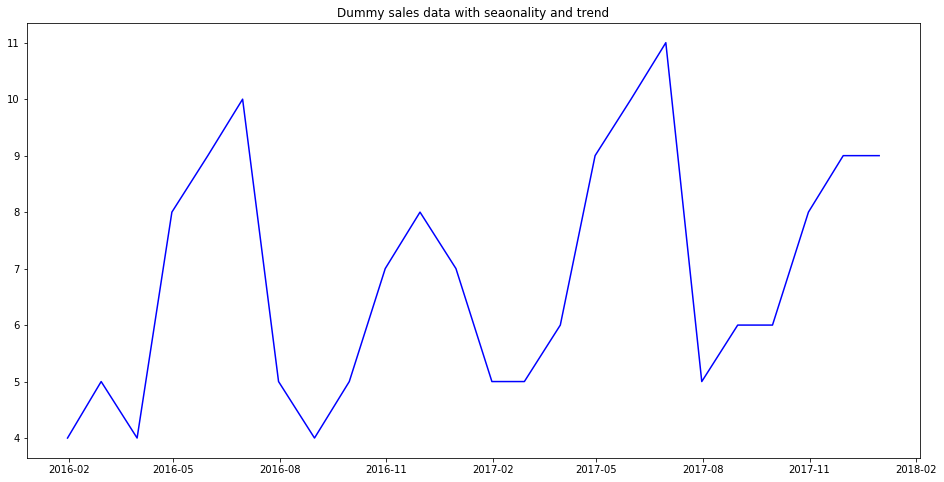

In [25]:
fig = plt.figure(figsize=[16,8]);
ax = fig.add_subplot(111);
ax.set_title('Dummy sales data with seaonality and trend')
ax.plot(dummy_df, color = (0,0,1));
#dummy_df.plot()

**Lets look at the trend and seasonality information for our dummy data.
As we see the trend is increasing and there are sales peaks in Q2 and Q4.
A quick look at the dummy values confirms this is what we would expect to see. The flat residuals curve is to be expected from this dummy data**

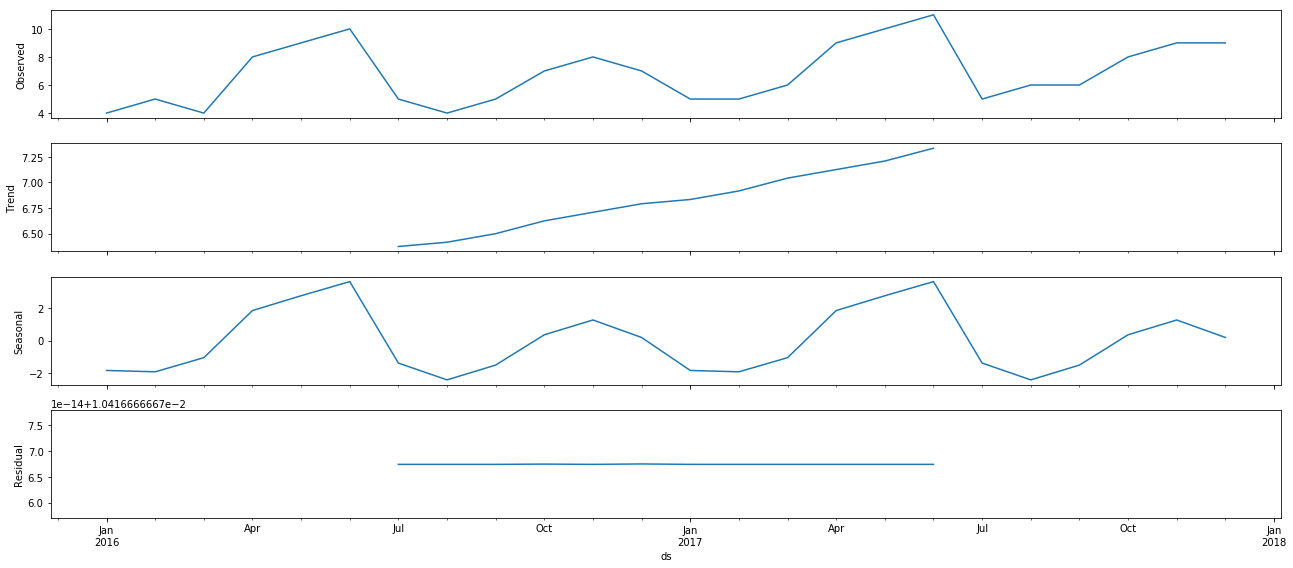

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(dummy_df, model='additative')
fig = decomposition.plot()
plt.show()

** Decomposition of real-world data **

In [27]:
df1_monthly.drop(["month","year"], axis=1, inplace=True)

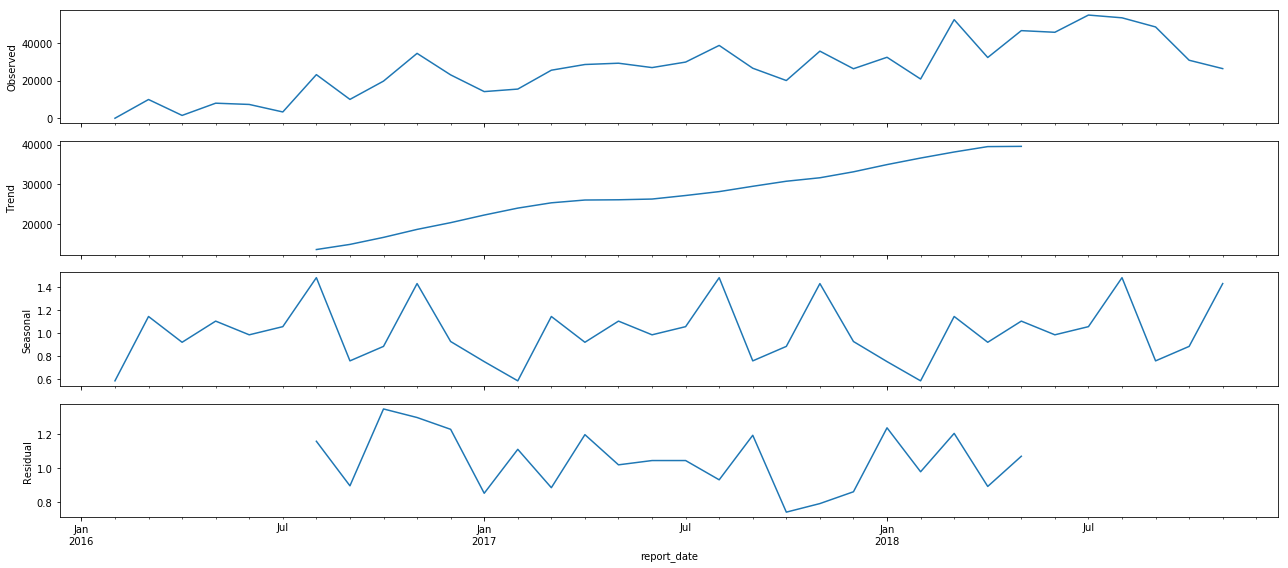

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(df1_monthly, model='multiplicatative')
fig = decomposition.plot()
plt.show()

** The plot appears to show a clear seasonal trend in the sales figures for this supplier.
We can check this in more detail using a autocorrelation test.**

**Note that we could measure deasonal decomposition for the daily and weekly sales data to identify seasonality at other frequencies if deemed useful.**

# 3 Time Series Stationarity Test
Aside from a visual interpretation of the data, there are also tests to determine how strongly time-series data is influenced by a trend (non-stationary). 
The Augmented Dickey-Fuller test is a widely used test for stationarity. 
The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
Here in the dummy data there is no unit root present and the data is stationary. Note this does not mean that there are no seasonal and trend effects.

In [29]:
#ADF test on dummy data
result = adfuller(dummy_df.y.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.026804
p-value: 0.000000
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


ADF statistic on real world sales data shows that we cannot reject the null-hypothesis at critical value of 5% and so we conclude that there is evidence that our data is non-stationary. This equivalent to saying that summary statistics such as mean and variance significantly vary across our data in this case.


In [30]:
#ADF test on real-world monthly sales data
result = adfuller(df1_monthly.ordered_product_sales.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.753757
p-value: 0.065189
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


** Interestingly if we do an ADF test on the weekly sales data then we can establish the stationarity proporty. **

In [31]:
#ADF test on real-world weekly sales data
result = adfuller(df1_weekly.ordered_product_sales.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.924422
p-value: 0.000031
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


# 4 Making a Time Series Stationary

The classical aproach to performing regression on a non-stationary time series dataset is to:

a) remove the trend and seasonal effects to make the data stationary.

b) fit a model to the now stationary data and make predictions

c)re-transform predictions to original scale by adding back trend and seasonality data 

An important class of time-series analysis nethods are the ARIMA family.
A detailed discussion on configuting these models is available here: http://ucanalytics.com/blogs/python-code-time-series-forecasting-arima-models-manufacturing-case-study-example/

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. 
P models the influence of the previous periods’ values on the current period
D is the difference order
Q models the influence of the previous period’s error terms on the current period’s error

Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all).
The residual data of most time series usually become trend-less after the first order differencing which is represented as ARIMA(0,1,0). 
As shown below our data also becomes stationary after a first order difference.

Text(0,0.5,'Ordered Product Sales')

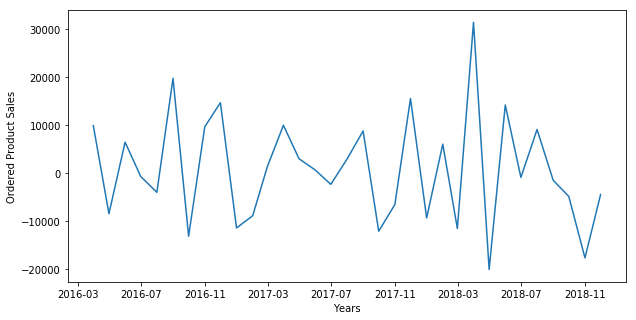

In [42]:
sales_ts = df1_monthly["ordered_product_sales"]
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Ordered Product Sales')

In [45]:
#ADF test on real-world weekly sales data
result = adfuller(sales_ts.diff(periods=1).dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.405011
p-value: 0.000000
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


** First-order differencing makes the monthly sales data stationary in terms of mean. 
Variance still appears to inrease with time. This can be smoothed using a log-transform.** 

Text(0,0.5,'Log (Ordered Product Sales)')

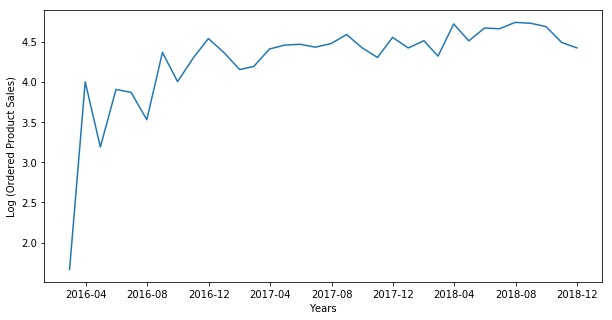

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Ordered Product Sales)')

Text(0,0.5,'Differenced Log (Ordered_Product_sales)')

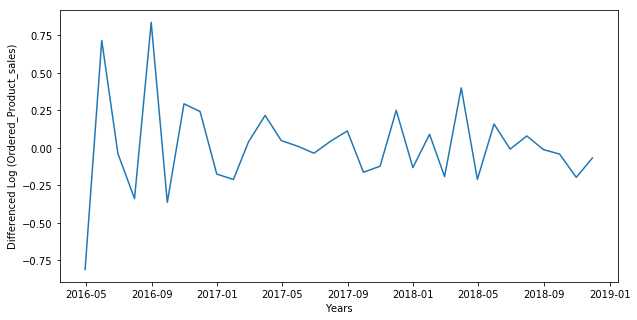

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1)[2:])
plt.xlabel('Years')
plt.ylabel('Differenced Log (Ordered_Product_sales)')


In [48]:
#ADF test on real-world weekly sales data
result = adfuller(np.log10(sales_ts).diff(periods=1)[2:].dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.880285
p-value: 0.000000
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


Step 5: Plot ACF and PACF to identify potential AR and MA model

Now, let us create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

In [37]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1)[2:] # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

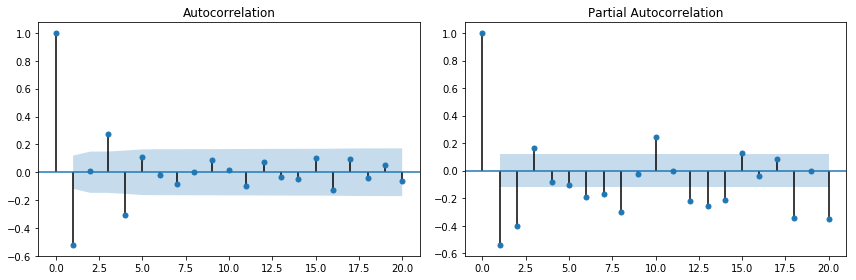

In [38]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=20, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=20, ax=axes[1], alpha=0.5)
plt.tight_layout()

There are some spikes in the plots outside the insignificant zone (dotted horizontal lines) and we can conclude that the residuals are not completely random. This implies that there is information available in residuals to be extracted by AR and MA models. There may be a seasonal component available in the residuals at the lag 3 (represented by spikes at lag 3 in both the ACF ad PCF graphs). 

I obtained the code for the grid search below for optimal pdq parameters from the blog linked to above. 

In [93]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]


In [94]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log[2:],
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 0, 0, 3)12 model - AIC:-0.09514638325495817


** This notebook has shown a worflow for visualizing and decomposing time series data. It has also shown statistical stationary test and how to transform a non-stationary time series into a stationary dataset for analysis.
A second notebook will present a number of time series forecasting methods. **